In [2]:
# Load the annotation data
from json import load
import numpy as np
from pathlib import Path

data_directory = "E:/Code/enpm809k/pose_data/images/single"
annotations = load(Path(data_directory + "/annotations.json").open())

y = [a for a in annotations]

# Check we have a annotation that looks right
print(y[0])

[[823, 845], [1056, 851], [948.1976, 166.7482], [817, 438], [1105, 454]]


In [3]:
# Load the images from disk
import cv2
from skimage.transform import resize
from tqdm.auto import trange
HEIGHT = 180
WIDTH = 320

x = np.zeros((len(y), HEIGHT, WIDTH, 3), dtype=np.float32)

for i in trange(0, len(y)):
    img = cv2.imread(f"{data_directory}/{i}.jpg")
    height, width, depth = img.shape
    img = resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (HEIGHT, WIDTH))
    x[i] = img
    y[i] = [[xy[0] / width, xy[1] / height] for xy in y[i]]

y = np.array([np.array(a).flatten() for a in y])
print(x[0].shape)
print(y[0])

c:\Users\jdobry\AppData\Local\pypoetry\Cache\virtualenvs\enpm809k-bYwqMXgM-py3.10\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 815/815 [01:41<00:00,  8.05it/s]

(180, 320, 3)
[0.42864583 0.78240741 0.55       0.78796296 0.49385292 0.15439648
 0.42552083 0.40555556 0.57552083 0.42037037]


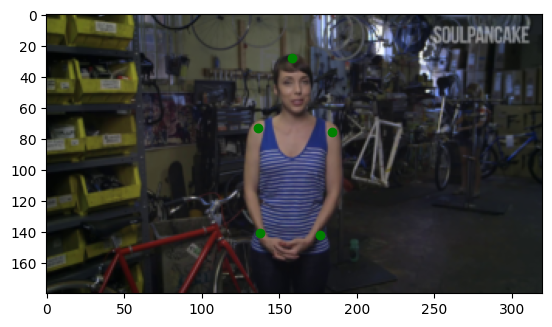

In [4]:
# Show a image from our dataset with the annotations
import matplotlib.pyplot as plt

def show_image(img, points, prediction = None):
    fig, ax = plt.subplots()
    ax.imshow(img)

    x_coords = []
    y_coords = []
    for idx, p in enumerate(points):
        if idx % 2 == 0:
            x_coords.append(p * WIDTH)
        else:
            y_coords.append(p * HEIGHT)
    plt.plot(x_coords, y_coords, "go")

    if prediction is not None:
        x_coords = []
        y_coords = []
        for idx in range(prediction.shape[0]):
            if idx % 2 == 0:
                x_coords.append(prediction[idx] * width)
            else:
                y_coords.append(prediction[idx] * height)
        plt.plot(x_coords, y_coords, "ro")
        
    plt.show()

show_image(x[0], y[0])

In [8]:
from tensorflow import keras
from keras import layers

inputs = layers.Input(shape=(HEIGHT, WIDTH, 3))

root = layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="swish")(inputs)
root = layers.BatchNormalization()(root)
root = layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="swish")(root)
root = layers.MaxPool2D(pool_size=2, strides=2, padding="valid")(root)

root = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="swish")(root)
root = layers.BatchNormalization()(root)
root = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="swish")(root)
root = layers.MaxPool2D(pool_size=2, strides=2, padding="valid")(root)

root = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="swish")(root)
root = layers.BatchNormalization()(root)
root = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="swish")(root)
root = layers.MaxPool2D(pool_size=2, strides=2, padding="valid")(root)

root = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="swish")(root)
root = layers.BatchNormalization()(root)
root = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="swish")(root)
root = layers.MaxPool2D(pool_size=2, strides=2, padding="valid")(root)

root = layers.Flatten()(root)

knees = layers.Dense(2048, activation="swish")(root)
knees = layers.Dense(1024, activation="swish")(knees)
knees = layers.Dense(4, activation="sigmoid")(knees)

head = layers.Dense(1024, activation="swish")(root)
head = layers.Dense(512, activation="swish")(head)
head = layers.Dense(2, activation="sigmoid")(head)

shoulders = layers.Dense(2048, activation="swish")(root)
shoulders = layers.Dense(1024, activation="swish")(shoulders)
shoulders = layers.Dense(4, activation="sigmoid")(shoulders)

outputs = layers.Concatenate()([knees, head, shoulders])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 180, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 180, 320, 12  3584        ['input_4[0][0]']                
                                8)                                                                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 180, 320, 12  512        ['conv2d_14[0][0]']              
 rmalization)                   8)                                                          

In [9]:
# Split the test data into train/test splits

TEST_SPLIT = 0.25
idx = int(np.floor(TEST_SPLIT * len(x)))

X_test = x[:idx]
X_train = x[idx:]
y_test = y[:idx]
y_train = y[idx:]

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(612, 180, 320, 3)
(612, 10)
(203, 180, 320, 3)
(203, 10)


In [ ]:
# Train the model
model.compile(optimizer="adam", loss=keras.losses.MeanSquaredError(), metrics=["acc"])
model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=2)

In [ ]:
# Test
test_scores = model.evaluate(X_test, y_test)
print(f"Test loss: {test_scores[0]}")
print(f"Test accuracy: {test_scores[1]}")

In [ ]:
# Visualize a test point
idx = np.random.randint(0, len(X_test))
img = X_test[idx]
prediction = model(np.expand_dims(img, axis=0))
show_image(img, y_test[idx], prediction.numpy().flatten())